# Facial detection and debiasing

Deploying fair, unbiased AI systems is critical to their long-term acceptance. Consider the task of facial detection: given an image, is it an image of a face?  This seemingly simple, but extremely important, task is subject to significant amounts of algorithmic bias among select demographics. 

In this notebook, we'll investigate [one recently published approach](https://dl.acm.org/doi/pdf/10.1145/3306618.3314243) to addressing algorithmic bias. The notebook is based in parts on [© MIT 6.S191: Introduction to Deep Learning](http://introtodeeplearning.com).

In [1]:
#pip install tqdm
#pip install opencv-python

In [3]:
import os
import tensorflow as tf
import IPython
import functools
import tarfile
import matplotlib.pyplot as plt
import numpy as np
import h5py
import cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, BatchNormalization, Flatten, Reshape, Dense

## 1. Data

For training our facial detection model, we will use two image datasets: one with "positive" examples (that is, faces) and one with "negative" examples (that is, images with other objects in them). We use:

1.   **Positive training data**: [CelebA Dataset](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html). A large-scale database (over 200K images) of celebrity faces.   
2.   **Negative training data**: [ImageNet](http://www.image-net.org/). Many (more than 1 mio.) images across many different categories. We take negative examples from a variety of non-human categories. 

Let's begin by importing approximately 50,000 images from each of these datasets (some pre-processing has already been done to make things more useable).

In [4]:
# Get the training data: both images from CelebA and ImageNet are combined in this '.h5' file
path_to_training_data =  tf.keras.utils.get_file('train_face.h5', 'https://www.dropbox.com/s/9bh4cetqj8ldhys/train_face.h5?dl=1')
data = h5py.File(path_to_training_data, 'r')

images = data['images'][:]
labels = data['labels'][:].astype(np.float32)

n = images.shape[0]

1263902720/1263889489 [==============================] - 90s 0us/step


The training set contains quite a few images:

In [5]:
n

109914

Play around with displaying images to get a sense of what the training data actually looks like:

In [6]:
face_images = images[np.where(labels==1)[0]]
not_face_images = images[np.where(labels==0)[0]]

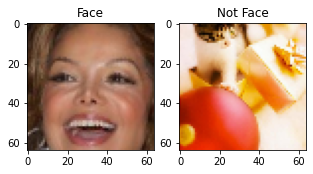

In [7]:
idx_face = 10
idx_not_face = 15

plt.figure(figsize=(5,5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(face_images[idx_face],cv2.COLOR_BGR2RGB))
plt.title("Face"); plt.grid(False)

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(not_face_images[idx_not_face],cv2.COLOR_BGR2RGB))
plt.title("Not Face"); plt.grid(False)

We will split off a number of images for validation and testing. Keep in mind that we have more than 100,000 images, so even a small percentage should be fine for this task. For example, we choose 3,000 validation and 3,000 test images.

In [8]:
X_train, X_other, y_train, y_other = train_test_split(images, labels, test_size = 6000, random_state=492)
X_valid, X_test, y_valid, y_test = train_test_split(X_other, y_other, test_size = 3000, random_state=271)

print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

(103914, 64, 64, 3)
(3000, 64, 64, 3)
(3000, 64, 64, 3)


## 2. CNN for face detection 

First, we'll define and train a CNN on the face detection task, and evaluate its accuracy. Later, we'll evaluate the performance of our debiased models against this baseline CNN. The CNN model has a relatively standard architecture consisting of a series of convolutional layers with batch normalization followed by two fully connected layers to flatten the convolution output and generate a class prediction. 

### Define and train the CNN model

We'll define our CNN model, and then train on the combined CelebA and ImageNet dataset.

Let's start with the model definition (we keep the baseline number of filters as a variable. This would be a good starting point to fine-tune the model later):

In [9]:
n_filters = 12

standard_classifier = tf.keras.Sequential([
    Conv2D(filters=1*n_filters, kernel_size=5,  strides=2, padding='same', activation='relu', input_shape = [64,64,3]),
    BatchNormalization(),

    Conv2D(filters=2*n_filters, kernel_size=5,  strides=2, padding='same', activation='relu'),
    BatchNormalization(),

    Conv2D(filters=4*n_filters, kernel_size=3,  strides=2, padding='same', activation='relu'),
    BatchNormalization(),

    Conv2D(filters=6*n_filters, kernel_size=3,  strides=2, padding='same', activation='relu'),
    BatchNormalization(),

    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid'),
    ])

standard_classifier.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 12)        912       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 12)       48        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 24)        7224      
                                                                 
 batch_normalization_1 (Batc  (None, 16, 16, 24)       96        
 hNormalization)                                                 
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 48)          10416     
                                                                 
 batch_normalization_2 (Batc  (None, 8, 8, 48)         1

We next train our standard model. Due to the time required, we will only use two epochs, but feel free to extend this and try out where you get. Even with two epochs, thanks to the huge number of images, we get quite the high accuracy.

In [10]:
standard_classifier.compile(loss="binary_crossentropy",
                              optimizer=tf.keras.optimizers.Adam(5e-4),
                              metrics=["accuracy"])

log = standard_classifier.fit(X_train, y_train,
                                batch_size = 32,
                                epochs=2,
                                validation_data = (X_valid,y_valid))

Epoch 1/2
3248/3248 [==============================] - 68s 21ms/step - loss: 0.0246 - accuracy: 0.9920 - val_loss: 0.0455 - val_accuracy: 0.9837
Epoch 2/2
3248/3248 [==============================] - 68s 21ms/step - loss: 0.0097 - accuracy: 0.9970 - val_loss: 0.0161 - val_accuracy: 0.9957


### Evaluate performance of the standard CNN

First, we evaluate the classification performance of our CelebA/ImageNet-trained standard CNN on the test dataset.

In [11]:
standard_classifier.evaluate(X_test, y_test)

94/94 [==============================] - 1s 6ms/step - loss: 0.0055 - accuracy: 0.9973


[0.005518102552741766, 0.9973333477973938]

This seems quite good, right? However, there is a catch, which we focus on next.

In particular, we are concerend about the potential of **human bias** in our model. Hence, we need to make sure the model works equally well for people of different demographics. Hence, we add an additional test set with images that have not been seen by our model so far. In particular, this test set has equal representation of two protected features: skin tone and gender. To label images based on skin tone as "Darker" or "Lighter", the [Fitzpatrick Scale](https://en.wikipedia.org/wiki/Fitzpatrick_scale) skin type classification system is employed.
Overall, we have four categories: dark-skinned female, dark-skinned male, light-skinned female, and light-skinned male. 

Let's load in the additional data and take a look at some sample faces.

In [12]:
path_to_face_data =  tf.keras.utils.get_file('faces.tar.gz', 'https://www.dropbox.com/s/rpxxplt6498llut/faces.tar.gz?dl=1')
file = tarfile.open(path_to_face_data)
file.extractall(os.path.abspath(os.path.join(path_to_face_data, os.pardir)))
file.close()

4530176/4521784 [==============================] - 0s 0us/step


In [13]:
test_faces = {
    "DF": [],
    "DM": [],
    "LF": [],
    "LM": []
}
for key in test_faces.keys():
    path = os.path.abspath(os.path.join(path_to_face_data, os.pardir, 'faces/'+key))
    for img in [f for f in os.listdir(path) if not f.startswith('.')]:
        try:
            img_arr = cv2.imread(os.path.join(path, img))
            img_arr = cv2.resize(img_arr, (64,64))[:,:,::-1]
            test_faces[key].append(img_arr)
        except Exception as e:
            print(e)

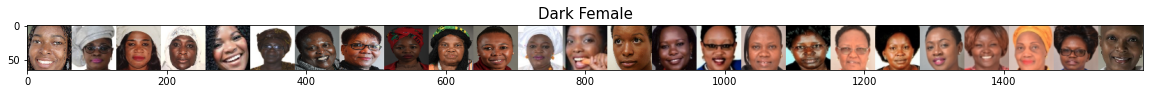

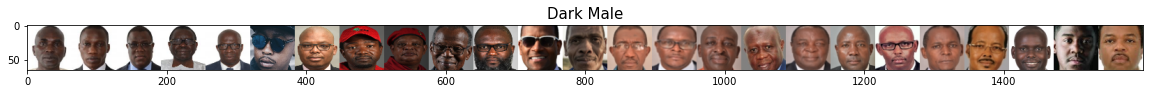

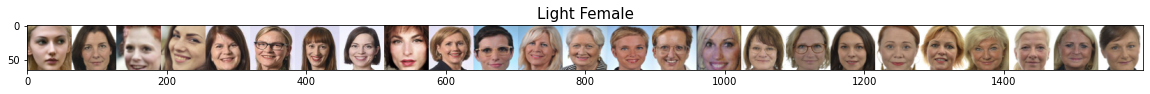

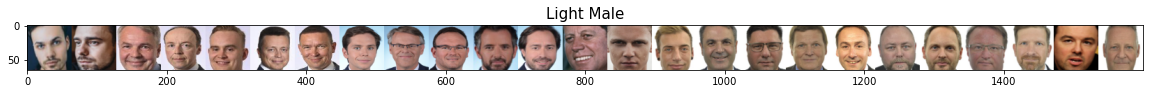

In [14]:
keys = ["Dark Female", "Dark Male","Light Female", "Light Male"]
for group, key in zip(test_faces,keys): 
    plt.figure(figsize=(20,20))
    plt.imshow(np.hstack(test_faces[group]))
    plt.title(key, fontsize=15)

Now, let's evaluated the probability of each of these face demographics being classified as a face using the standard CNN classifier we've just trained. In particular, we plot, for each demographic, the probability the classifier gives that the image is a face:

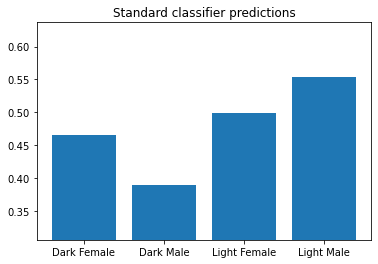

In [15]:
xx = range(len(keys))
yy = [np.mean(standard_classifier.predict(np.array([cv2.cvtColor(test_faces[group][i],cv2.COLOR_RGB2BGR) for i in range(len(test_faces[group]))],dtype=np.float32))) for group in test_faces]
plt.bar(xx, yy)
plt.xticks(xx, keys)
plt.ylim(max(0,np.min(yy)-np.ptp(yy)/2.), np.max(yy)+np.ptp(yy)/2.)
plt.title("Standard classifier predictions");

Take a look at the accuracies for this first model and the predictions across these four groups.
- What do you observe?
- Would you consider this model biased or unbiased?
- What are some reasons why a trained model may be biased?

## 3. Debiasing variational autoencoder (DB-VAE)

As you saw, the accuracy of the CNN varies across the four demographics we looked at. To think about why this may be, consider the dataset the model was trained on, CelebA. If certain features, such as dark skin or hats, are *rare* in CelebA, the model may end up biased against these as a result of training with a biased dataset. That is to say, its classification accuracy will be worse on faces that have under-represented features, such as dark-skinned faces or faces with hats, relevative to faces with features well-represented in the training data! This is a problem.

Our goal is to train a **debiased** version of this classifier -- one that accounts for potential disparities in feature representation within the training data. Specifically, to build a debiased facial classifier, we'll train a model that **learns a probabilistic representation of the images** (a variational autoencoder, short VAE) to the face training data. The model then uses this information to mitigate unwanted biases by sampling faces with rare features, like dark skin or hats, **more frequently** during training. It does so in an unsupervised way: roughly, images whose underlying representations ("latent features") are more rare, are sampled more often. Because these images are sampled more often, our model is forced to learn a more accurate representation for them.

### Define the DB-VAE architecture

We start by defining DB-VAE architecture. To build the DB-VAE, we will use the standard CNN classifier from above as our encoder (with slightly modified outputs), and then define a decoder network. We will use a latent space ("encoding") with 100 latent variables.

The decoder network will take as input the sampled latent variables, run them through a series of deconvolutional layers ("transpose convolutions"), and output a reconstruction of the original input image.

In [17]:
n_filters = 12

def create_encoder(n_outputs):
    model = tf.keras.Sequential([
        Conv2D(filters=1*n_filters, kernel_size=5,  strides=2, padding='same', activation='relu', input_shape = [64,64,3]),
        BatchNormalization(),

        Conv2D(filters=2*n_filters, kernel_size=5,  strides=2, padding='same', activation='relu'),
        BatchNormalization(),

        Conv2D(filters=4*n_filters, kernel_size=3,  strides=2, padding='same', activation='relu'),
        BatchNormalization(),

        Conv2D(filters=6*n_filters, kernel_size=3,  strides=2, padding='same', activation='relu'),
        BatchNormalization(),

        Flatten(),
        Dense(512, activation='relu'),
        Dense(n_outputs)
    ])
    return model

def create_decoder():
    model = tf.keras.Sequential([
        Dense(4*4*6*n_filters, activation='relu'),
        Reshape(target_shape=(4,4,6*n_filters)),
        
        Conv2DTranspose(filters=4*n_filters, kernel_size=3,  strides=2, padding='same', activation='relu'),
        Conv2DTranspose(filters=2*n_filters, kernel_size=3,  strides=2, padding='same', activation='relu'),
        Conv2DTranspose(filters=1*n_filters, kernel_size=5,  strides=2, padding='same', activation='relu'),
        Conv2DTranspose(filters=3, kernel_size=5,  strides=2, padding='same', activation='relu')
    ])
    return model

Now, we will put the encoder and decoder together to define the DB-VAE. This is a bit more complex than building an autoencoder, and we need a more customized model, which we can build by subclassinf the `tf.keras.Model` class. We also need a separate "sampling" function that allows to draw samples from the "latent space".

Note that at this point, there is nothing special about how we put the model together that makes it a "debiasing" model - that will come when we define the training operation.

In [18]:
def sampling(z_mean, z_logsigma):
    batch, latent_dim = z_mean.shape
    epsilon = tf.random.normal(shape=(batch, latent_dim))

    z = z_mean + tf.math.exp(0.5 * z_logsigma) * epsilon
    return z

In [19]:
class DB_VAE(tf.keras.Model):
    def __init__(self, latent_dim):
        super(DB_VAE, self).__init__()
        self.latent_dim = latent_dim

        # Define the number of outputs for the encoder. Recall that we have 
        # `latent_dim` latent variables, as well as a supervised output for the 
        # classification.
        num_encoder_dims = 2*self.latent_dim + 1

        self.encoder = create_encoder(num_encoder_dims)
        self.decoder = create_decoder()

    # function to feed images into encoder, encode the latent space, and output
    # classification probability 
    def encode(self, x):
        # encoder output
        encoder_output = self.encoder(x)

        # classification prediction
        y_logit = tf.expand_dims(encoder_output[:, 0], -1)
        # latent variable distribution parameters
        z_mean = encoder_output[:, 1:self.latent_dim+1] 
        z_logsigma = encoder_output[:, self.latent_dim+1:]

        return y_logit, z_mean, z_logsigma

    # VAE reparameterization: given a mean and logsigma, sample latent variables
    def reparameterize(self, z_mean, z_logsigma):
        z = sampling(z_mean, z_logsigma)
        return z

    # Decode the latent space and output reconstruction
    def decode(self, z):
        reconstruction = self.decoder(z)
        return reconstruction

    # The call function will be used to pass inputs x through the core VAE
    def call(self, x): 
        # Encode input to a prediction and latent space
        y_logit, z_mean, z_logsigma = self.encode(x)
        z = self.reparameterize(z_mean, z_logsigma)
        recon = self.decode(z)
        return y_logit, z_mean, z_logsigma, recon

    # Predict face or not face logit for given input x
    def predict(self, x):
        y_logit, z_mean, z_logsigma = self.encode(x)
        return y_logit

dbvae = DB_VAE(latent_dim=100)

### Adaptive resampling for debiasing with DB-VAE

Now, let's define the actual resampling algorithm that allows us to add debiasing to the process. First, we define a short helper function `get_latent_mu` that returns the latent variable means from the encoder after a batch of images is inputted to the network.

In [20]:
# Function to return the means for an input image batch
def get_latent_mu(images, dbvae, batch_size=1024):
    N = images.shape[0]
    mu = np.zeros((N, latent_dim))
    for start_ind in range(0, N, batch_size):
        end_ind = min(start_ind+batch_size, N+1)
        batch = (images[start_ind:end_ind]).astype(np.float32)/255.
        _, batch_mu, _ = dbvae.encode(batch)
        mu[start_ind:end_ind] = batch_mu
    return mu

We can then define `get_training_sample_probabilities`, which decides how the training set should be sampled, in order to represent all latent features appropriately. Basically, if an image's latent features are relatively underrepresented, we assign a higher probability to that image.
The function takes an argument `smoothing_fac`, which tunes the degree of debiasing: for `smoothing_fac=0`, debiasing is at its most extreme.

In [21]:
def get_training_sample_probabilities(images, dbvae, bins=10, smoothing_fac=0.001): 
    print("Recomputing the sampling probabilities")
    
    mu = get_latent_mu(images, dbvae)

    # sampling probabilities for the images
    training_sample_p = np.zeros(mu.shape[0])
    
    # consider the distribution for each latent variable 
    for i in range(latent_dim):
      
        latent_distribution = mu[:,i]
        # generate a histogram of the latent distribution
        hist_density, bin_edges =  np.histogram(latent_distribution, density=True, bins=bins)

        # find which latent bin every data sample falls in 
        bin_edges[0] = -float('inf')
        bin_edges[-1] = float('inf')
        
        # call the digitize function to find which bins in the latent distribution 
        #    every data sample falls in to
        bin_idx = np.digitize(latent_distribution, bin_edges)

        # smooth the density function
        hist_smoothed_density = hist_density + smoothing_fac
        hist_smoothed_density = hist_smoothed_density / np.sum(hist_smoothed_density)

        # invert the density function 
        p = 1.0/(hist_smoothed_density[bin_idx-1])
        
        p = p / np.sum(p)
        
        # update sampling probabilities by considering whether the newly
        #     computed p is greater than the existing sampling probabilities.
        training_sample_p = np.maximum(p, training_sample_p)
        
    # final normalization
    training_sample_p /= np.sum(training_sample_p)

    return training_sample_p

Next, we define `get_batch`, which provides a way to select a new batch of images from the training set (both faces and non-faces) with a given batch size (recall that in each iteration of training, we don't use all our training data, but a "mini-batch" subset of the training data). We choose non-faces uniformly at random. For faces, we also select randomly, but we use the probabilities computed with `get_training_sample_probabilities` to better represent all latent features.

In [22]:
train_inds = np.random.permutation(np.arange(X_train.shape[0]))
pos_train_inds = train_inds[ y_train[train_inds, 0] == 1.0 ]
neg_train_inds = train_inds[ y_train[train_inds, 0] != 1.0 ]

def get_batch(n, p_pos=None):
    selected_pos_inds = np.random.choice(pos_train_inds, size=n//2, replace=False, p=p_pos)
    selected_neg_inds = np.random.choice(neg_train_inds, size=n//2, replace=False)
    selected_inds = np.concatenate((selected_pos_inds, selected_neg_inds))

    sorted_inds = np.sort(selected_inds)
    train_img = (X_train[selected_inds,:,:,:]/255.).astype(np.float32)
    train_label = y_train[selected_inds,:]
    return (train_img, train_label)

Finally, we need to compute an appropriate loss function in each iteration. We combine three types of losses:
- reconstruction loss: you should be familiar with this from autoencoders - how good does our output recreate our input? Note that this is only relevant when the image is of a face!
- latent loss: this is specific to variational autoencoders and helps to bring the distributions learned by the encoder into the "right shape" (essentially, we want to have standard normal distributions)
- classification loss: this is the loss that is purely based on the quality of our classification, i.e., the usual binary cross-entropy

In [23]:
def debiasing_loss_function(x, x_pred, y, y_logit, mu, logsigma, kl_weight=0.0005):

    latent_loss = 0.5 * tf.reduce_sum(tf.exp(logsigma) + tf.square(mu) - 1.0 - logsigma, axis=1)
    reconstruction_loss = tf.reduce_mean(tf.abs(x-x_pred), axis=(1,2,3))
    vae_loss = kl_weight * latent_loss + reconstruction_loss

    classification_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=y_logit)
    face_indicator = tf.cast(tf.equal(y, 1), tf.float32)

    total_loss = tf.reduce_mean(
      classification_loss + 
      face_indicator * vae_loss
    )

    return total_loss, classification_loss

### Training the DB-VAE

Now that we've defined the resampling update, we can train our DB-VAE model on the CelebA/ImageNet training data, and run the above operations to re-weight the importance of particular data points as we train the model. 

The training process is a bit more manual here than what we have seen before. This is because we are defining many aspects of the process ourselves, instead of using standard modules. Don't worry too much about the details - we are still using forward- and back-propagation and employing the `Adam` algorithm to run the optimization.

Starting epoch 6/6
Recomputing the sampling probabilities


  0%|          | 0/3247 [00:00<?, ?it/s]

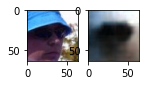

 15%|█▌        | 499/3247 [00:19<01:45, 26.06it/s]

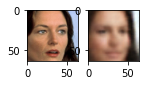

 31%|███       | 1000/3247 [00:38<01:26, 26.09it/s]

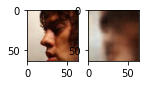

 46%|████▌     | 1498/3247 [00:57<01:06, 26.22it/s]

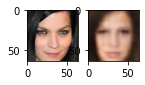

 62%|██████▏   | 1999/3247 [01:17<00:47, 26.18it/s]

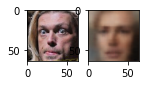

 77%|███████▋  | 2500/3247 [01:36<00:28, 26.53it/s]

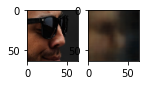

 92%|█████████▏| 2998/3247 [01:55<00:09, 26.46it/s]

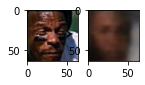

100%|██████████| 3247/3247 [02:04<00:00, 26.03it/s]


In [24]:
# Hyperparameters
batch_size = 32
learning_rate = 5e-4
latent_dim = 100

# DB-VAE needs slightly more epochs to train since its more complex than 
# the standard classifier so we use 6 instead of 2
num_epochs = 6  

# instantiate a new DB-VAE model and optimizer
dbvae = DB_VAE(100)
optimizer = tf.keras.optimizers.Adam(learning_rate)

# To define the training operation, we will use tf.function which is a powerful tool 
#   that lets us turn a Python function into a TensorFlow computation graph.
@tf.function
def debiasing_train_step(x, y):

    with tf.GradientTape() as tape:
        # Feed input x into dbvae. Note that this is using the DB_VAE call function!
        y_logit, z_mean, z_logsigma, x_recon = dbvae(x)
        # call the DB_VAE loss function to compute the loss
        loss, class_loss = debiasing_loss_function(x, x_recon, y, y_logit, z_mean, z_logsigma)
  
    # use the GradientTape.gradient method to compute the gradients.
    grads = tape.gradient(loss, dbvae.trainable_variables)
  

    # apply gradients to variables
    optimizer.apply_gradients(zip(grads, dbvae.trainable_variables))
    return loss

# get training faces
all_faces = X_train[pos_train_inds]

if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists

# The training loop -- outer loop iterates over the number of epochs
for i in range(num_epochs):

    IPython.display.clear_output(wait=True)
    print("Starting epoch {}/{}".format(i+1, num_epochs))

    # Recompute data sampling proabilities
    p_faces = get_training_sample_probabilities(all_faces, dbvae, smoothing_fac=0.001)

    # get a batch of training data and compute the training step
    for j in tqdm(range(train_inds.shape[0] // batch_size)):
        # load a batch of data
        (x, y) = get_batch(batch_size, p_pos=p_faces)
        # loss optimization
        loss = debiasing_train_step(x, y)
        
        # Plot the progress every 500 steps
        if j % 500 == 0:
            plt.figure(figsize=(2,1))
            plt.subplot(1, 2, 1)

            idx = np.where(y==1)[0][0]
            plt.imshow(cv2.cvtColor(x[idx],cv2.COLOR_BGR2RGB))
            plt.grid(False)

            plt.subplot(1, 2, 2)
            _, _, _, recon = dbvae(x)
            recon = np.clip(recon, 0, 1)
            plt.imshow(cv2.cvtColor(recon[idx],cv2.COLOR_BGR2RGB))
            plt.grid(False)

            plt.show()

### Evaluation of DB-VAE on Test Dataset

We check the accuracy of the model on the test set:

In [25]:
from sklearn.metrics import accuracy_score
y_pred = dbvae.predict(np.array(X_test/255., dtype=np.float32))
y_pred = tf.squeeze(tf.sigmoid(y_pred))
y_pred = y_pred > 0.5
accuracy_score(y_test,y_pred)

0.9993333333333333

Finally let's test our DB-VAE model on the extra test dataset, looking specifically at its accuracy on each the "Dark Female", "Dark Male", "Light Female", and "Light Male" demographics. We will compare the performance of this debiased model against the (potentially biased) standard CNN from earlier.

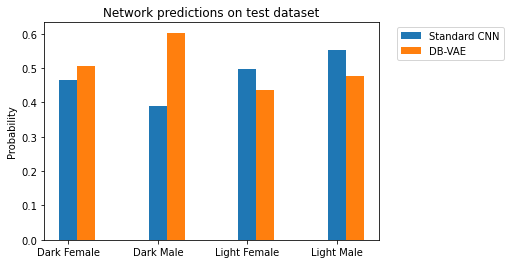

In [26]:
dbvae_logits = [dbvae.predict(np.array([cv2.cvtColor(test_faces[group][i],cv2.COLOR_RGB2BGR) for i in range(len(test_faces[group]))] , dtype=np.float32)/255.) for group in test_faces]
dbvae_probs = tf.squeeze(tf.sigmoid(dbvae_logits))

xx = np.arange(len(keys))
plt.bar(xx, yy, width=0.2, label="Standard CNN")
plt.bar(xx+0.2, dbvae_probs.numpy().mean(1), width=0.2, label="DB-VAE")
plt.xticks(xx, keys); 
plt.title("Network predictions on test dataset")
plt.ylabel("Probability"); plt.legend(bbox_to_anchor=(1.04,1), loc="upper left");

Consider the following questions:
- How do accuracy and bias of the approach compare to the (non-debiased) baseline? Is the result surprising?
- In which applications (facial detection or not) is debiasing important? Are there some where you don’t want to debias?
- Do you have other ideas for ways to address issues of human bias in models?
- Should it be necessary that companies demonstrate that models are not biased?

## Appendix: more details about the DB-VAE

### Variational autoencoder (VAE) for learning latent structure (*not* debiasing yet)

Consider first the structure of a variational autoencoder (VAE):

![The concept of a VAE](https://i.ibb.co/3s4S6Gc/vae.jpg)

As shown in the schematic, VAEs rely on an encoder-decoder structure to learn a latent representation of the input data. In the context of computer vision, the encoder network takes in input images, encodes them into a series of variables defined by a mean and standard deviation, and then draws from the distributions defined by these parameters to generate a set of sampled latent variables. The decoder network then "decodes" these variables to generate a reconstruction of the original image, which is used during training to help the model identify which latent variables are important to learn. 

Let's formalize two key aspects of the VAE model and define relevant functions for each.

#### The VAE loss function

In practice, how can we train a VAE? In learning the latent space, we constrain the means and standard deviations to approximately follow a unit Gaussian. Recall that these are learned parameters, and therefore must factor into the loss computation, and that the decoder portion of the VAE is using these parameters to output a reconstruction that should closely match the input image, which also must factor into the loss. What this means is that we'll have two terms in our VAE loss function:

1.  **Latent loss ($L_{KL}$)**: measures how closely the learned latent variables match a unit Gaussian and is defined by the Kullback-Leibler (KL) divergence.
2.   **Reconstruction loss ($L_{x}{(x,\hat{x})}$)**: measures how accurately the reconstructed outputs match the input and is given by the $L^1$ norm of the input image and its reconstructed output.

The equation for the latent loss is provided by:

$$L_{KL}(\mu, \sigma) = \frac{1}{2}\sum_{j=0}^{k-1} (\sigma_j + \mu_j^2 - 1 - \log{\sigma_j})$$

The equation for the reconstruction loss is provided by:

$$L_{x}{(x,\hat{x})} = ||x-\hat{x}||_1$$

Thus for the VAE loss we have:

$$L_{VAE} = c\cdot L_{KL} + L_{x}{(x,\hat{x})}$$

where $c$ is a weighting coefficient used for regularization.

#### The VAE reparameterization process

VAEs use a "reparameterization  trick" for sampling learned latent variables. Instead of the VAE encoder generating a single vector of real numbers for each latent variable, it generates a vector of means and a vector of standard deviations that are constrained to roughly follow Gaussian distributions. We then sample from the standard deviations and add back the mean to output this as our sampled latent vector. Formalizing this for a latent variable $z$ where we sample $\epsilon \sim \mathcal{N}(0,(I))$ we have: 

$$z = \mu + e^{\left(\frac{1}{2} \cdot \log{\Sigma}\right)}\circ \epsilon$$

where $\mu$ is the mean and $\Sigma$ is the covariance matrix. This is useful because it lets us neatly define the loss function for the VAE, generate randomly sampled latent variables, achieve improved network generalization, **and** make our complete VAE network differentiable so that it can be trained via backpropagation. Quite powerful!

### Debiasing variational autoencoder (DB-VAE)

We use the general idea behind the VAE architecture to build a model, termed a debiasing variational autoencoder or DB-VAE, to mitigate (potentially) unknown biases present within the training idea.

#### The DB-VAE model

The key idea behind this debiasing approach is to use the latent variables learned via a VAE to adaptively re-sample the CelebA data during training. Specifically, we alter the probability that a given image is used during training based on how often its latent features appear in the dataset. So, faces with rarer features (like dark skin, sunglasses, or hats) should become more likely to be sampled during training, while the sampling probability for faces with features that are over-represented in the training dataset should decrease (relative to uniform random sampling across the training data). 

A general schematic of the DB-VAE approach is shown below:

![DB-VAE](attachment:image.png)

Recall that we want to apply our DB-VAE to a *supervised classification* problem - the facial detection task. Importantly, note how the encoder portion in the DB-VAE architecture also outputs a single supervised variable, $z_o$, corresponding to the class prediction - face or not face. Usually, VAEs are not trained to output any supervised variables (such as a class prediction)! This is another key distinction between the DB-VAE and a traditional VAE. 

Keep in mind that we only want to learn the latent representation of *faces*, as that's what we're ultimately debiasing against, even though we are training a model on a binary classification problem. We'll need to ensure that, **for faces**, our DB-VAE model both learns a representation of the unsupervised latent variables, captured by the distribution $q_\phi(z|x)$, **and** outputs a supervised class prediction $z_o$, but that, **for negative examples**, it only outputs a class prediction $z_o$.

#### Defining the DB-VAE loss function

This means we'll need to be a bit clever about the loss function for the DB-VAE. The form of the loss will depend on whether it's a face image or a non-face image that's being considered. 

For **face images**, our loss function will have two components:


1.   **VAE loss ($L_{VAE}$)**: consists of the latent loss and the reconstruction loss.
2.   **Classification loss ($L_y(y,\hat{y})$)**: standard cross-entropy loss for a binary classification problem. 

In contrast, for images of **non-faces**, our loss function is solely the classification loss. 

We can write a single expression for the loss by defining an indicator variable $\mathcal{I}_f$which reflects which training data are images of faces ($\mathcal{I}_f(y) = 1$ ) and which are images of non-faces ($\mathcal{I}_f(y) = 0$). Using this, we obtain:

$$L_{total} = L_y(y,\hat{y}) + \mathcal{I}_f(y)\Big[L_{VAE}\Big]$$

#### Adaptive resampling for automated debiasing with DB-VAE

So, how can we actually use DB-VAE to train a debiased facial detection classifier?

Recall the DB-VAE architecture: as input images are fed through the network, the encoder learns an estimate $\mathcal{Q}(z|X)$ of the latent space. We want to increase the relative frequency of rare data by increased sampling of under-represented regions of the latent space. We can approximate $\mathcal{Q}(z|X)$ using the frequency distributions of each of the learned latent variables, and then define the probability distribution of selecting a given datapoint $x$ based on this approximation. These probability distributions will be used during training to re-sample the data.